# Tutorial - Sampling Problem
---
The final state of an annealing process is a Gibbs state, which is a resource we can use to produce some interesting probabilistic distribution.

## Ising model

A $3\times 3$ spin lattice has a Hamiltonian like

$$ H = \sum_{\mbox{i and j are neighbors}}Z_iZ_j .$$

Under a thermal equilibrium, we define an order parameter 

$$ P = \frac{1}{N}|\sum_{i=1}^N(-1)^{x_i+y_i}S_i |.$$

$S_i$ is the measured spin value on site $i$, $x_i, y_i$ are coords of this site, $N$ sites totally.  We will study how this parameter changes with inverse temperature.

#### Set up the model

We map this spin lattice to a 9-qubit annealer.  Each qubit plays as a spin on a site and is assigned a pair of coords. For example, the 3th qubit is located at $(1, 0)$, the 4th is at $(1, 1)$, and so on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from phalanx import Annealer

beta = 1.0
num_qubits = 9
ism = Annealer(beta, num_qubits)

In [3]:
connection = [
    [0,1,0,1,0,0,0,0,0],
    [0,0,1,0,1,0,0,0,0],
    [0,0,0,0,0,1,0,0,0],
    [0,0,0,0,1,0,1,0,0],
    [0,0,0,0,0,1,0,1,0],
    [0,0,0,0,0,0,0,0,1],
    [0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,1],
    [0,0,0,0,0,0,0,0,0],
]
ism.set_connection(connection)

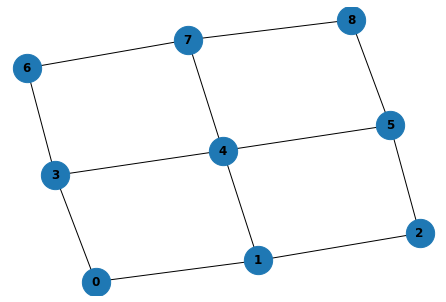

In [4]:
ism.draw_topology()

By sampling the final state of annealing for many times, we can estimate the $P$ parameter for a fixed inverse temperature $\beta$.  By varying $\beta$ and repeating this procedure, we can get a relation between $P$ and $\beta$.

In [5]:
shots = 100  # Time of measurements for each beta.
beta_list = np.linspace(-2, 2, 20)  # Different beta values.
P_list = []

for ism.beta in beta_list:
    P = 0
    for i in range(shots):
        config = np.array(ism.measure()).reshape(3, 3)  # Reshape the qubit result to an array.
        tmp = 0
        for idx in range(3):
            for jdx in range(3):
                tmp += (-1)**(idx+jdx) * config[idx, jdx]
        P += abs(tmp) / 9.  # P for a certain outcome.
    P_list.append(P / shots)  # P for a certain beta.

The relation can be show in a figure.  We omit the error bars in analysis to simplify the calculation.

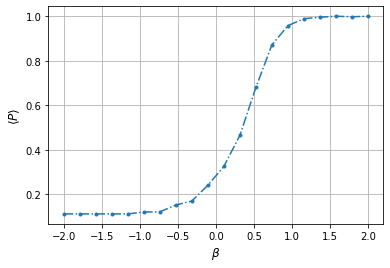

In [6]:
fig, ax = plt.subplots()
_ = plt.plot(beta_list, P_list, '.-.')
_ = ax.set_ylabel(r'$\langle P \rangle$', fontsize=12)
_ = ax.set_xlabel(r'$\beta$', fontsize=12)
_ = ax.grid(True)

## Artificial distribution

Generate a given distribution is a hard problem on classical problem, since any distribution is made from the built-in pseudo random number generator.  This generator is not really random, if you are dealing a long period process, this could be a disaster.

Can a quantum annealer output real random number? Yes, and it can do more than just the uniform random numbers.  We will follow a concrete case below.

#### Problem

Try to make a probabilistic distribution which returns $1,2,3$ with equal probabilities, but never returns $0$ and other numbers.  In other words, it means a distribution as 

$$ p(1) = p(2) = p(3) = 1/3 $$

#### Solve it

If we create an annealer with such a Hamiltonian

$$ diag(3,-1,-1,-1) $$

The final Gibbs state will be 

$$ e^{-3\beta},e^{1\beta},e^{1\beta},e^{1\beta} $$

By increasing $\beta$, the probability to return the first eigenstate will be supressed a lot.  The latter three eigenstates are $|1,-1\rangle,|-1,1\rangle,|-1,-1\rangle$, which by some mapping can be transfered to $|01\rangle, |10\rangle, |11\rangle$ , corresponding to $1,2,3$.

Actually, this Hamiltonian is just 

$$ H = Z_1 + Z_2 + Z_1 Z_2 $$

In [7]:
beta = 10.  # Higher beta can suppress higher energy state.
num_qubits = 2
dis = Annealer(beta, num_qubits)

In [8]:
connectin = [
    [1, 1],
    [0, 1]
]
dis.set_connection(connectin)

Let's measure this annealer to test the result.

In [9]:
count = [0] * 4
for i in range(1000):
    output = np.array(dis.measure())
    # A proper transformation for notation is involved below.
    output[0] = (output[0] + 1) / 2.
    output[1] = (output[1] + 1) / 2.
    count[int(3 - output[0] * 2 - output[-1])] += 1
    
print('Got 0 for '+str(count[0])+' times')
print('Got 1 for '+str(count[1])+' times')
print('Got 2 for '+str(count[2])+' times')
print('Got 3 for '+str(count[3])+' times')

Got 0 for 0 times
Got 1 for 312 times
Got 2 for 354 times
Got 3 for 334 times


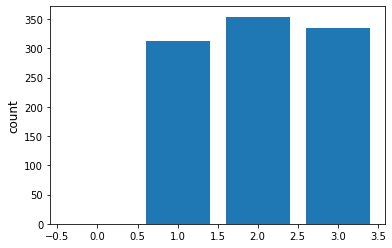

In [10]:
_ = plt.bar(range(4),count)
_ = plt.ylabel('count',fontsize=12)

From the figure, we can confirm the desired distribution is produced on the annealer.

#### Think

An interesting problem is can _phalanx_ generate any distribution on natural numbers.  This means can _phalanx_ create a diagonal Hamiltonian holds any possible real numbers on its diagonal places.  For example, can we set an annealer with such a Hamiltonian

$$ diag(4,0,0,0) $$

The answer is no.  This is limited by our Hamiltonian's formalism, the form is lack of a part corresponding to identity matrix.